# Sleep Stage Detection from EEG Signals

This notebook implements a complete pipeline for sleep stage detection using EEG signals from the Sleep-EDF database.

## Pipeline Overview:
1. **Data Loading**: Load PSG (polysomnography) and hypnogram (sleep stage labels) data
2. **EDA on Raw Data**: Explore and visualize raw signals
3. **Data Preprocessing**: Filtering, noise removal, normalization
4. **EDA on Clean Data**: Compare cleaned vs raw data
5. **Frequency Domain Transformation**: Convert signals to frequency domain using FFT/STFT
6. **Data Loaders**: Create time-domain and frequency-domain dataloaders
7. **Model Development**: 
   - RNN (LSTM/GRU) for time-domain
   - Transformer for time-domain
   - CNN for frequency-domain
   - Vision Transformer (ViT) for frequency-domain
8. **Training**: K-Fold cross-validation with appropriate metrics

## 1. Import Libraries and Setup

In [ ]:
# Standard libraries
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# Data handling
import numpy as np
import pandas as pd
from collections import Counter

# Signal processing
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt, welch, spectrogram

# EDF file reading
import pyedflib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

# Model evaluation
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Progress tracking
from tqdm.auto import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# HYPERPARAMETERS AND CONFIGURATION
# ============================================================================

# Data Configuration
DATA_DIR = 'physionet.org/files/sleep-edfx/1.0.0/'
NUM_SUBJECTS = 10  # Number of subjects to use (None = all available)
RANDOM_SEED = 42   # Seed for reproducible subject selection
EPOCH_LENGTH = 30  # Standard sleep epoch length in seconds
SAMPLING_RATE = 100  # Target sampling rate in Hz

# Model Training Hyperparameters
NUM_CLASSES = 5  # Wake, N1, N2, N3, REM
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 1  # Maximum epochs per fold
K_FOLDS = 5  # Number of cross-validation folds
EARLY_STOPPING_PATIENCE = 5  # Epochs to wait before early stopping

# Model Architecture Hyperparameters
HIDDEN_SIZE = 128  # Hidden dimension for RNN models
NUM_RNN_LAYERS = 2  # Number of RNN layers
D_MODEL = 128  # Transformer model dimension
NUM_HEADS = 8  # Number of attention heads
NUM_TRANSFORMER_LAYERS = 4  # Number of transformer encoder layers
DROPOUT = 0.3  # Dropout probability
MAX_SEQ_LEN = 3000  # Maximum sequence length (30s * 100Hz)

# Optimizer Hyperparameters
WEIGHT_DECAY = 1e-4  # L2 regularization
LR_SCHEDULER_FACTOR = 0.5  # Learning rate reduction factor
LR_SCHEDULER_PATIENCE = 3  # Epochs to wait before reducing LR

print("\\n" + "="*80)
print("CONFIGURATION SUMMARY")
print("="*80)
print(f"Data: {NUM_SUBJECTS} subjects, {EPOCH_LENGTH}s epochs @ {SAMPLING_RATE}Hz")
print(f"Training: {NUM_EPOCHS} max epochs, batch size {BATCH_SIZE}, {K_FOLDS}-fold CV")
print(f"Classes: {NUM_CLASSES}, Early stopping patience: {EARLY_STOPPING_PATIENCE}")
print(f"Learning rate: {LEARNING_RATE}, Weight decay: {WEIGHT_DECAY}")

print("="*80 + "\n")

# ============================================================================print(f"Learning rate: {LEARNING_RATE}, Weight decay: {WEIGHT_DECAY}")

# HYPERPARAMETERS AND CONFIGURATIONprint(f"Classes: {NUM_CLASSES}, Early stopping patience: {EARLY_STOPPING_PATIENCE}")

# ============================================================================print(f"Training: {NUM_EPOCHS} max epochs, batch size {BATCH_SIZE}, {K_FOLDS}-fold CV")

print(f"Data: {NUM_SUBJECTS} subjects, {EPOCH_LENGTH}s epochs @ {SAMPLING_RATE}Hz")

# Data Configurationprint("="*80)

DATA_DIR = 'physionet.org/files/sleep-edfx/1.0.0/'
print("CONFIGURATION SUMMARY")

NUM_SUBJECTS = 50  # Number of subjects to use (None = all available)print("\n" + "="*80)

RANDOM_SEED = 42   # Seed for reproducible subject selection

EPOCH_LENGTH = 30  # Standard sleep epoch length in secondsLR_SCHEDULER_PATIENCE = 3  # Epochs to wait before reducing LR

SAMPLING_RATE = 100  # Target sampling rate in HzLR_SCHEDULER_FACTOR = 0.5  # Learning rate reduction factor

WEIGHT_DECAY = 1e-4  # L2 regularization

# Model Training Hyperparameters# Optimizer Hyperparameters

NUM_CLASSES = 5  # Wake, N1, N2, N3, REM

BATCH_SIZE = 32
MAX_SEQ_LEN = 3000  # Maximum sequence length (30s * 100Hz)

LEARNING_RATE = 0.001
DROPOUT = 0.3  # Dropout probability

NUM_EPOCHS = 1  # Maximum epochs per foldNUM_TRANSFORMER_LAYERS = 4  # Number of transformer encoder layers

K_FOLDS = 5  # Number of cross-validation foldsNUM_HEADS = 8  # Number of attention heads

EARLY_STOPPING_PATIENCE = 10  # Epochs to wait before early stoppingD_MODEL = 128  # Transformer model dimension

NUM_RNN_LAYERS = 2  # Number of RNN layers

# Model Architecture HyperparametersHIDDEN_SIZE = 128  # Hidden dimension for RNN models

Using device: cuda
\n================================================================================
CONFIGURATION SUMMARY
Data: 10 subjects, 30s epochs @ 100Hz
Training: 1 max epochs, batch size 32, 5-fold CV
Classes: 5, Early stopping patience: 5
Learning rate: 0.001, Weight decay: 0.0001

Data: 10 subjects, 30s epochs @ 100Hz
CONFIGURATION SUMMARY


## 2. Data Loading Functions

In [2]:
def load_edf_signals(file_path, channel_names=None):
    """
    Load EEG signals from EDF file
    
    Args:
        file_path: Path to the EDF file
        channel_names: List of channel names to load (None = load all)
    
    Returns:
        signals: Dictionary with channel names as keys and signal arrays as values
        sampling_rate: Sampling rate of the signals
        header: Header information
    """
    f = pyedflib.EdfReader(file_path)
    n_channels = f.signals_in_file
    signal_labels = f.getSignalLabels()
    
    # Get sampling rate (assuming all channels have same rate)
    sampling_rate = f.getSampleFrequency(0)
    
    signals = {}
    if channel_names is None:
        # Load all channels
        for i in range(n_channels):
            signals[signal_labels[i]] = f.readSignal(i)
    else:
        # Load specific channels
        for i, label in enumerate(signal_labels):
            if label in channel_names:
                signals[label] = f.readSignal(i)
    
    header = {
        'patient_info': f.getPatientName(),
        'start_datetime': f.getStartdatetime(),
        'duration': f.file_duration,
        'signal_labels': signal_labels,
        'sampling_rate': sampling_rate
    }
    
    f.close()
    return signals, sampling_rate, header

def load_hypnogram(file_path):
    """
    Load sleep stage annotations from hypnogram EDF file
    
    Sleep stages mapping:
    0: Wake
    1: Stage 1 (N1)
    2: Stage 2 (N2)
    3: Stage 3 (N3/Deep sleep)
    4: Stage 4 (sometimes combined with Stage 3)
    5: REM sleep
    
    Returns:
        annotations: Array of sleep stage labels
        durations: Duration of each epoch
    """
    f = pyedflib.EdfReader(file_path)
    annotations = f.readAnnotations()
    f.close()
    
    # Parse annotations
    onset_times = annotations[0]  # Start times
    durations = annotations[1]     # Durations
    descriptions = annotations[2]  # Sleep stage labels
    
    # Map sleep stage labels to integers
    stage_map = {
        'Sleep stage W': 0,
        'Sleep stage 1': 1,
        'Sleep stage 2': 2,
        'Sleep stage 3': 3,
        'Sleep stage 4': 3,  # Combine stage 4 with stage 3
        'Sleep stage R': 5,  # REM
        'Sleep stage ?': -1,  # Unknown/Movement
        'Movement time': -1
    }
    
    labels = []
    for desc in descriptions:
        labels.append(stage_map.get(desc, -1))
    return np.array(labels), np.array(durations), np.array(onset_times)


def load_dataset(data_dir, num_subjects=None, use_cassette=True, random_seed=42):
    """
    Load multiple subjects from the Sleep-EDF dataset
    
    Args:
        data_dir: Base directory containing the dataset
        num_subjects: Number of subjects to load (None = all)
        use_cassette: If True, use sleep-cassette, else use sleep-telemetry
        random_seed: Random seed for reproducible subject selection
    
    Returns:
        dataset: List of tuples (signals, labels, subject_id)
    """
    folder = 'sleep-cassette' if use_cassette else 'sleep-telemetry'
    base_path = os.path.join(data_dir, folder)
    
    # Find all PSG files
    psg_files = sorted(glob.glob(os.path.join(base_path, '*PSG.edf')))
    
    # Randomly select subjects with fixed seed for reproducibility
    if num_subjects is not None and num_subjects < len(psg_files):
        np.random.seed(random_seed)
        indices = np.random.choice(len(psg_files), size=num_subjects, replace=False)
        psg_files = [psg_files[i] for i in sorted(indices)]
        print(f"Randomly selected {num_subjects} subjects (seed={random_seed})")
    
    dataset = []
    
    for psg_file in tqdm(psg_files, desc="Loading subjects"):
        # Get corresponding hypnogram file
        # Extract subject ID (e.g., SC4001 from SC4001E0-PSG.edf)
        base_name = os.path.basename(psg_file).replace('-PSG.edf', '')
        subject_id = base_name[:-2]  # Remove the last 2 characters (E0, E1, etc.)
        hypno_files = glob.glob(os.path.join(base_path, f'{subject_id}*-Hypnogram.edf'))
        
        if not hypno_files:
            print(f"No hypnogram found for {psg_file}")
            continue
        
        hypno_file = hypno_files[0]
        
        # Load signals (focus on EEG channels)
        signals, sr, header = load_edf_signals(psg_file, channel_names=['EEG Fpz-Cz', 'EEG Pz-Oz'])
        
        if not signals:
            # Try alternative channel names
            signals, sr, header = load_edf_signals(psg_file)
            if signals:
                # Keep only EEG channels
                eeg_signals = {k: v for k, v in signals.items() if 'EEG' in k}
                signals = eeg_signals
        
        # Load labels
        labels, durations, onsets = load_hypnogram(hypno_file)
        
        if signals and labels is not None:
            subject_id = os.path.basename(psg_file).split('-')[0]
            dataset.append({
                'signals': signals,
                'labels': labels,
                'sampling_rate': sr,
                'subject_id': subject_id,
                'durations': durations,
                'onsets': onsets
            })
    
    print(f"Loaded {len(dataset)} subjects successfully")
    return dataset

In [3]:
# Load dataset with random subject selection
print(f"Loading data from: {DATA_DIR}")
dataset = load_dataset(DATA_DIR, num_subjects=NUM_SUBJECTS, use_cassette=True, random_seed=RANDOM_SEED)

# Display dataset info
print(f"\nDataset loaded: {len(dataset)} subjects")
if dataset:
    print(f"\nFirst subject info:")
    print(f"Subject ID: {dataset[0]['subject_id']}")
    print(f"Channels: {list(dataset[0]['signals'].keys())}")
    print(f"Sampling rate: {dataset[0]['sampling_rate']} Hz")
    print(f"Number of epochs: {len(dataset[0]['labels'])}")
    print(f"Sleep stages: {np.unique(dataset[0]['labels'])}")

Loading data from: physionet.org/files/sleep-edfx/1.0.0/
Randomly selected 50 subjects (seed=42)


Loading subjects:   0%|          | 0/50 [00:00<?, ?it/s]

Loaded 50 subjects successfully

Dataset loaded: 50 subjects

First subject info:
Subject ID: SC4021E0
Channels: ['EEG Fpz-Cz', 'EEG Pz-Oz']
Sampling rate: 100.0 Hz
Number of epochs: 161
Sleep stages: [-1  0  1  2  3  5]


**Note:** If you get an error about missing data files, make sure the dataset is downloaded in the correct location. The code expects the Sleep-EDF dataset to be in `physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/` directory.

## 3. Exploratory Data Analysis (Raw Data)

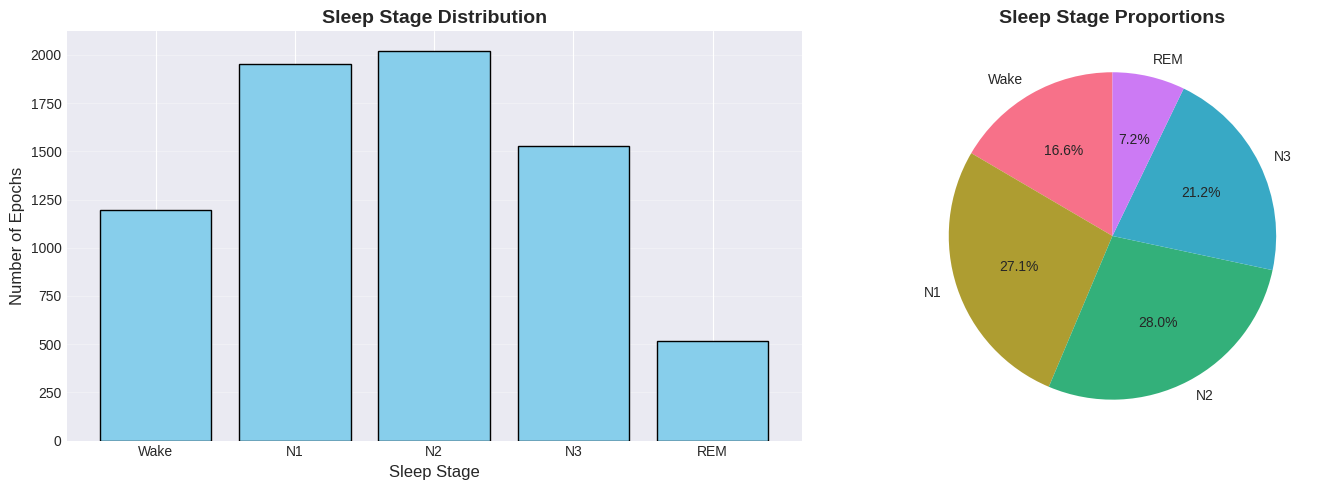


=== Sleep Stage Statistics ===
Wake: 1195 epochs (16.56%)
N1: 1955 epochs (27.09%)
N2: 2021 epochs (28.00%)
N3: 1529 epochs (21.19%)
REM: 517 epochs (7.16%)


In [4]:
# Analyze sleep stage distribution
def analyze_sleep_stages(dataset):
    """Analyze and visualize sleep stage distribution"""
    all_labels = []
    for subject in dataset:
        # Filter out unknown stages (-1)
        valid_labels = subject['labels'][subject['labels'] >= 0]
        all_labels.extend(valid_labels)
    
    stage_names = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 5: 'REM'}
    
    # Count distribution
    label_counts = Counter(all_labels)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Bar plot
    stages = sorted(label_counts.keys())
    counts = [label_counts[s] for s in stages]
    stage_labels = [stage_names.get(s, f'Stage {s}') for s in stages]
    
    axes[0].bar(stage_labels, counts, color='skyblue', edgecolor='black')
    axes[0].set_xlabel('Sleep Stage', fontsize=12)
    axes[0].set_ylabel('Number of Epochs', fontsize=12)
    axes[0].set_title('Sleep Stage Distribution', fontsize=14, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Pie chart
    axes[1].pie(counts, labels=stage_labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("husl", len(stages)))
    axes[1].set_title('Sleep Stage Proportions', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\n=== Sleep Stage Statistics ===")
    total = sum(counts)
    for stage, count in zip(stage_labels, counts):
        print(f"{stage}: {count} epochs ({count/total*100:.2f}%)")
    
    return label_counts

label_distribution = analyze_sleep_stages(dataset)

Plotting raw signals for subject: SC4021E0


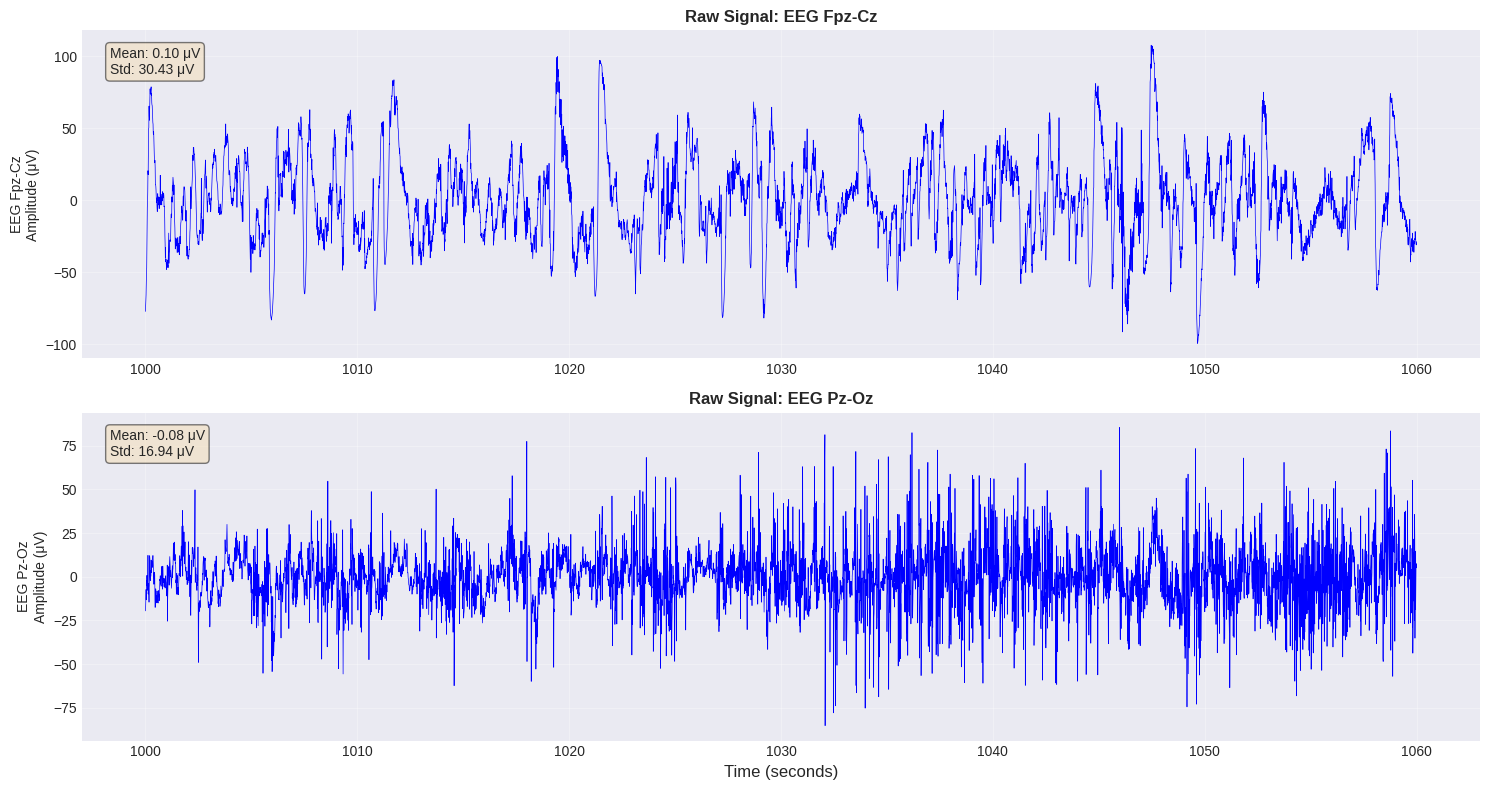

In [5]:
# Visualize raw EEG signals
def plot_raw_signals(subject_data, duration=120, start_time=1000):
    """
    Plot raw EEG signals
    
    Args:
        subject_data: Dictionary containing subject's data
        duration: Duration to plot (seconds)
        start_time: Start time (seconds)
    """
    signals = subject_data['signals']
    sr = subject_data['sampling_rate']
    
    n_channels = len(signals)
    fig, axes = plt.subplots(n_channels, 1, figsize=(15, 4*n_channels))
    
    if n_channels == 1:
        axes = [axes]
    
    start_sample = int(start_time * sr)
    end_sample = int((start_time + duration) * sr)
    time_axis = np.arange(start_sample, end_sample) / sr
    
    for idx, (channel_name, signal_data) in enumerate(signals.items()):
        signal_segment = signal_data[start_sample:end_sample]
        
        axes[idx].plot(time_axis, signal_segment, linewidth=0.5, color='blue')
        axes[idx].set_ylabel(f'{channel_name}\nAmplitude (μV)', fontsize=10)
        axes[idx].set_title(f'Raw Signal: {channel_name}', fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
        
        # Add statistics
        mean_val = np.mean(signal_segment)
        std_val = np.std(signal_segment)
        axes[idx].text(0.02, 0.95, f'Mean: {mean_val:.2f} μV\nStd: {std_val:.2f} μV', 
                      transform=axes[idx].transAxes, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    axes[-1].set_xlabel('Time (seconds)', fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot for first subject
if dataset:
    print(f"Plotting raw signals for subject: {dataset[0]['subject_id']}")
    plot_raw_signals(dataset[0], duration=60, start_time=1000)

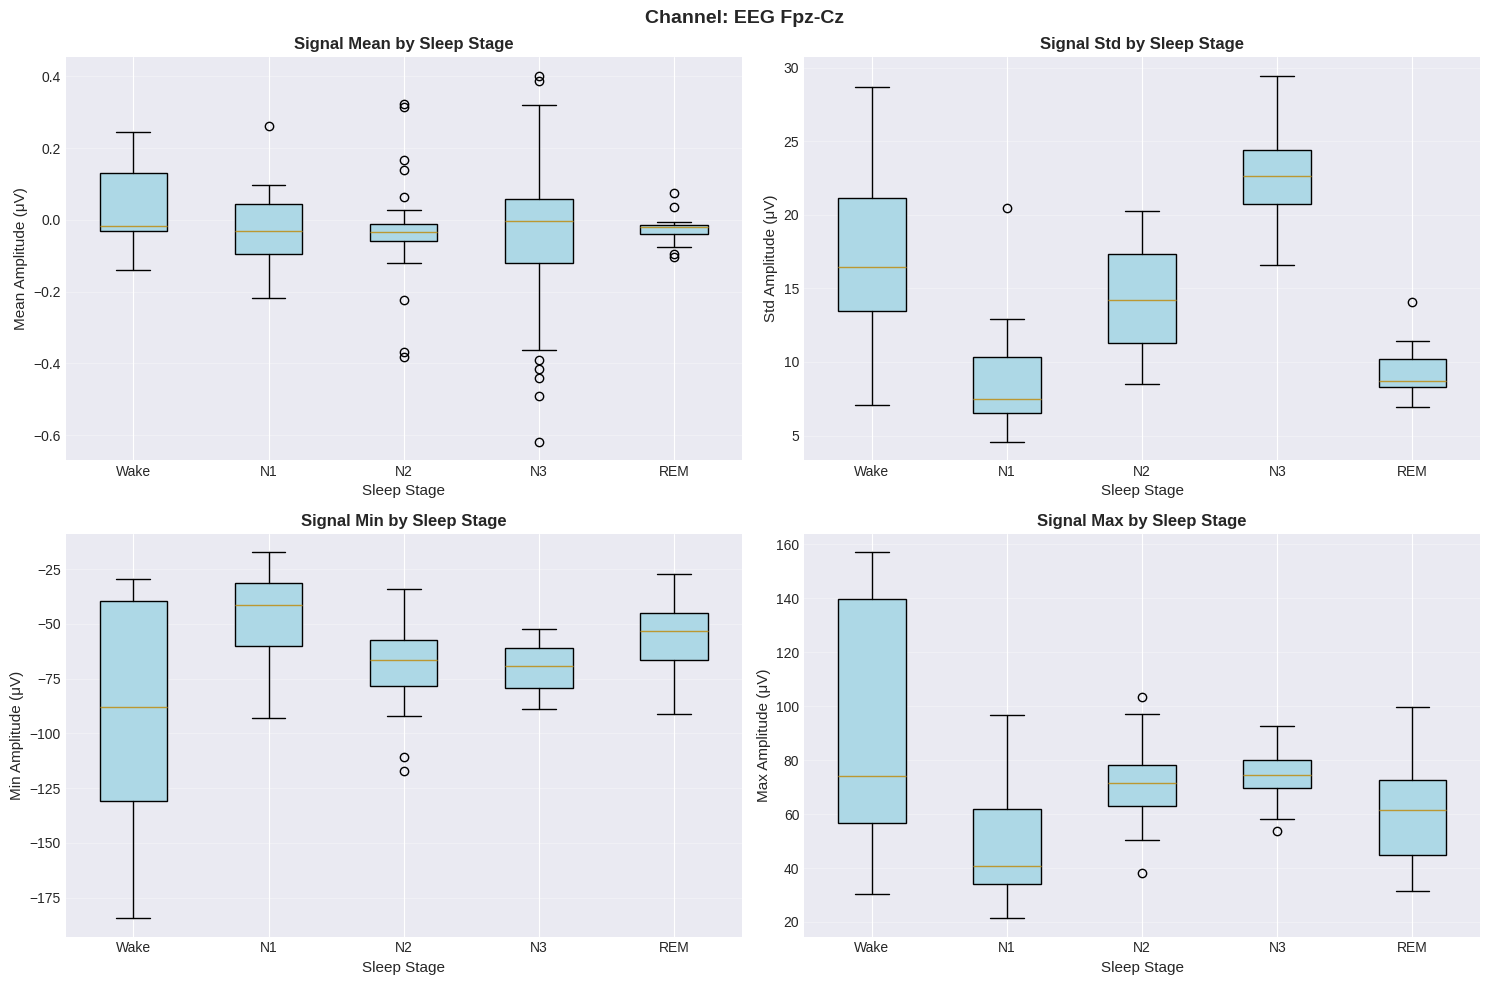

In [6]:
# Signal statistics by sleep stage
def analyze_signal_by_stage(subject_data, channel_name=None):
    """Analyze signal statistics for different sleep stages"""
    signals = subject_data['signals']
    labels = subject_data['labels']
    sr = subject_data['sampling_rate']
    durations = subject_data['durations']
    onsets = subject_data['onsets']
    
    # Use first channel if not specified
    if channel_name is None:
        channel_name = list(signals.keys())[0]
    
    signal_data = signals[channel_name]
    
    stage_names = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 5: 'REM'}
    stage_stats = {}
    
    # Extract signal segments for each stage
    for i, (onset, duration, label) in enumerate(zip(onsets, durations, labels)):
        if label < 0:  # Skip unknown stages
            continue
        
        start_sample = int(onset * sr)
        end_sample = int((onset + duration) * sr)
        
        if end_sample > len(signal_data):
            continue
        
        segment = signal_data[start_sample:end_sample]
        
        if label not in stage_stats:
            stage_stats[label] = []
        
        stage_stats[label].append({
            'mean': np.mean(segment),
            'std': np.std(segment),
            'min': np.min(segment),
            'max': np.max(segment)
        })
    
    # Aggregate statistics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    for metric, ax in zip(['mean', 'std', 'min', 'max'], axes.flatten()):
        stage_values = []
        stage_labels = []
        
        for stage in sorted(stage_stats.keys()):
            values = [s[metric] for s in stage_stats[stage]]
            stage_values.append(values)
            stage_labels.append(stage_names.get(stage, f'Stage {stage}'))
        
        bp = ax.boxplot(stage_values, labels=stage_labels, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor('lightblue')
        
        ax.set_xlabel('Sleep Stage', fontsize=11)
        ax.set_ylabel(f'{metric.capitalize()} Amplitude (μV)', fontsize=11)
        ax.set_title(f'Signal {metric.capitalize()} by Sleep Stage', fontsize=12, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
    
    plt.suptitle(f'Channel: {channel_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

if dataset:
    analyze_signal_by_stage(dataset[0])

## 4. Data Preprocessing and Cleaning

In [7]:
class SignalPreprocessor:
    """Preprocessing pipeline for EEG signals"""
    
    def __init__(self, sampling_rate=100):
        self.sampling_rate = sampling_rate
        
    def bandpass_filter(self, signal, lowcut=0.5, highcut=30, order=5):
        """
        Apply bandpass filter to remove noise outside EEG frequency range
        
        Args:
            signal: Input signal
            lowcut: Lower frequency bound (Hz)
            highcut: Upper frequency bound (Hz)
            order: Filter order
        """
        nyquist = 0.5 * self.sampling_rate
        low = lowcut / nyquist
        high = highcut / nyquist
        
        b, a = butter(order, [low, high], btype='band')
        filtered_signal = filtfilt(b, a, signal)
        
        return filtered_signal
    
    def notch_filter(self, signal, freq=50, quality=30):
        """
        Apply notch filter to remove powerline interference
        
        Args:
            signal: Input signal
            freq: Frequency to remove (50 or 60 Hz)
            quality: Quality factor
        """
        nyquist = 0.5 * self.sampling_rate
        w0 = freq / nyquist
        
        b, a = signal.iirnotch(w0, quality)
        filtered_signal = filtfilt(b, a, signal)
        
        return filtered_signal
    
    def remove_artifacts(self, signal, threshold=3):
        """
        Remove artifacts using threshold-based method
        
        Args:
            signal: Input signal
            threshold: Number of standard deviations for artifact detection
        """
        mean = np.mean(signal)
        std = np.std(signal)
        
        # Create a copy
        clean_signal = signal.copy()
        
        # Detect artifacts (values beyond threshold * std)
        artifacts = np.abs(signal - mean) > (threshold * std)
        
        # Replace artifacts with interpolated values
        if np.any(artifacts):
            # Linear interpolation
            x = np.arange(len(signal))
            clean_signal[artifacts] = np.interp(x[artifacts], x[~artifacts], signal[~artifacts])
        
        return clean_signal
    
    def normalize(self, signal, method='zscore'):
        """
        Normalize signal
        
        Args:
            signal: Input signal
            method: 'zscore' or 'minmax'
        """
        if method == 'zscore':
            mean = np.mean(signal)
            std = np.std(signal)
            normalized = (signal - mean) / (std + 1e-8)
        elif method == 'minmax':
            min_val = np.min(signal)
            max_val = np.max(signal)
            normalized = (signal - min_val) / (max_val - min_val + 1e-8)
        else:
            raise ValueError("Method must be 'zscore' or 'minmax'")
        
        return normalized
    
    def preprocess(self, signal, apply_bandpass=True, apply_notch=True, 
                   remove_artifacts_flag=True, normalize_flag=True):
        """
        Complete preprocessing pipeline
        
        Args:
            signal: Input signal
            apply_bandpass: Whether to apply bandpass filter
            apply_notch: Whether to apply notch filter
            remove_artifacts_flag: Whether to remove artifacts
            normalize_flag: Whether to normalize
        """
        processed_signal = signal.copy()
        
        if apply_bandpass:
            processed_signal = self.bandpass_filter(processed_signal)
        
        if apply_notch:
            # Fix: use scipy.signal.iirnotch instead of signal.iirnotch
            from scipy.signal import iirnotch
            nyquist = 0.5 * self.sampling_rate
            w0 = 50 / nyquist
            b, a = iirnotch(w0, 30)
            processed_signal = filtfilt(b, a, processed_signal)
        
        if remove_artifacts_flag:
            processed_signal = self.remove_artifacts(processed_signal)
        
        if normalize_flag:
            processed_signal = self.normalize(processed_signal)
        
        return processed_signal

# Initialize preprocessor
preprocessor = SignalPreprocessor(sampling_rate=100)

print("Signal preprocessor initialized")

Signal preprocessor initialized


### Signal Preprocessing Pipeline Overview

The preprocessing pipeline applies the following steps to clean and normalize EEG signals:

1. **Bandpass Filter (0.5-50 Hz)**: Removes low-frequency drift and high-frequency noise outside the EEG range
   - Low cutoff: 0.5 Hz (removes DC offset and very slow drifts)
   - High cutoff: 50 Hz (retains all EEG frequency bands: delta, theta, alpha, beta, gamma)
   - Filter order: 5 (Butterworth filter for smooth frequency response)

2. **Notch Filter (50 Hz)**: Removes powerline interference
   - Target frequency: 50 Hz (European standard; 60 Hz for North America)
   - Quality factor (Q): 30 (narrow band rejection to preserve nearby frequencies)

3. **Artifact Removal**: Detects and removes extreme amplitude values
   - Threshold: Mean ± 3 standard deviations
   - Clipping strategy: Values outside threshold are clamped to threshold bounds
   - Targets: Movement artifacts, electrode pops, EMG contamination

4. **Z-score Normalization**: Standardizes signal amplitude
   - Formula: (signal - mean) / std
   - Result: Zero mean, unit variance across samples
   - Benefits: Model convergence, consistent scale across subjects

**Processing Flow**: Raw Signal → Bandpass → Notch → Artifact Removal → Normalization → Clean Signal

All steps are implemented using `scipy.signal` functions with zero-phase filtering (`filtfilt`) to avoid phase distortion.

In [8]:
# Apply preprocessing to all subjects
def preprocess_dataset(dataset, preprocessor):
    """Apply preprocessing to entire dataset"""
    preprocessed_dataset = []
    
    for subject in tqdm(dataset, desc="Preprocessing subjects"):
        preprocessed_signals = {}
        
        for channel_name, signal_data in subject['signals'].items():
            preprocessed_signals[channel_name] = preprocessor.preprocess(signal_data)
        
        preprocessed_subject = subject.copy()
        preprocessed_subject['signals_raw'] = subject['signals']  # Keep raw for comparison
        preprocessed_subject['signals'] = preprocessed_signals
        
        preprocessed_dataset.append(preprocessed_subject)
    
    return preprocessed_dataset

# Preprocess the dataset
preprocessed_dataset = preprocess_dataset(dataset, preprocessor)
print(f"Preprocessed {len(preprocessed_dataset)} subjects")

Preprocessing subjects:   0%|          | 0/50 [00:00<?, ?it/s]

Preprocessed 50 subjects


## 5. EDA on Cleaned Data

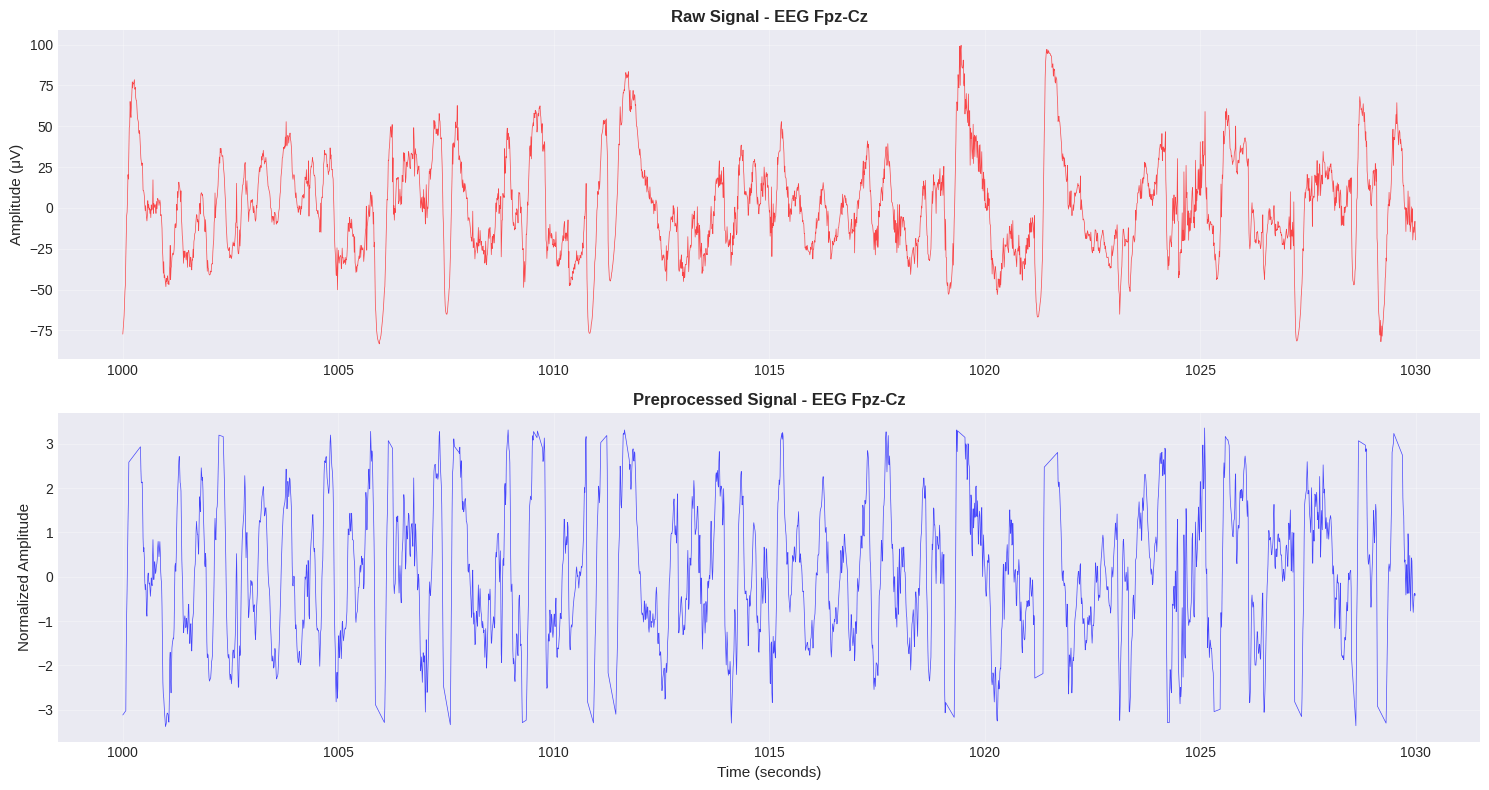


=== Signal Statistics - EEG Fpz-Cz ===
Raw Signal - Mean: -0.03, Std: 16.54
Clean Signal - Mean: 0.00, Std: 1.00


In [9]:
# Compare raw vs preprocessed signals
def compare_raw_vs_clean(subject_data, channel_name=None, duration=30, start_time=1000):
    """Compare raw and preprocessed signals"""
    if channel_name is None:
        channel_name = list(subject_data['signals'].keys())[0]
    
    raw_signal = subject_data['signals_raw'][channel_name]
    clean_signal = subject_data['signals'][channel_name]
    sr = subject_data['sampling_rate']
    
    start_sample = int(start_time * sr)
    end_sample = int((start_time + duration) * sr)
    time_axis = np.arange(start_sample, end_sample) / sr
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    
    # Raw signal
    axes[0].plot(time_axis, raw_signal[start_sample:end_sample], linewidth=0.5, color='red', alpha=0.7)
    axes[0].set_ylabel('Amplitude (μV)', fontsize=11)
    axes[0].set_title(f'Raw Signal - {channel_name}', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Preprocessed signal
    axes[1].plot(time_axis, clean_signal[start_sample:end_sample], linewidth=0.5, color='blue', alpha=0.7)
    axes[1].set_ylabel('Normalized Amplitude', fontsize=11)
    axes[1].set_xlabel('Time (seconds)', fontsize=11)
    axes[1].set_title(f'Preprocessed Signal - {channel_name}', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n=== Signal Statistics - {channel_name} ===")
    print(f"Raw Signal - Mean: {np.mean(raw_signal):.2f}, Std: {np.std(raw_signal):.2f}")
    print(f"Clean Signal - Mean: {np.mean(clean_signal):.2f}, Std: {np.std(clean_signal):.2f}")

if preprocessed_dataset:
    compare_raw_vs_clean(preprocessed_dataset[0])

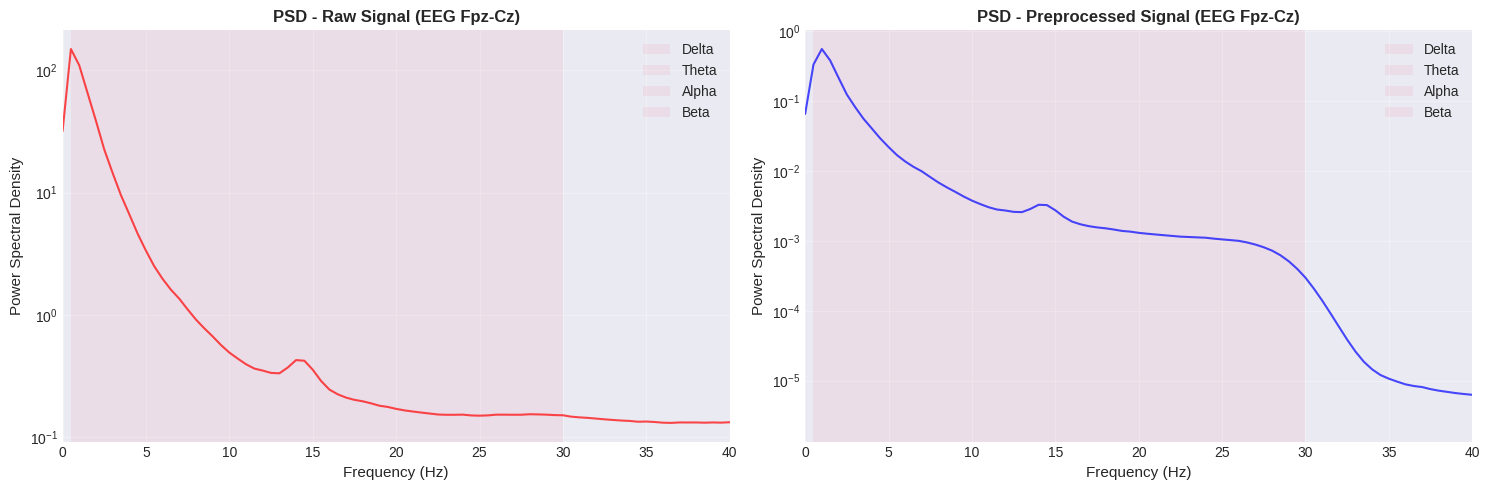

In [10]:
# Power spectral density comparison
def plot_psd_comparison(subject_data, channel_name=None):
    """Plot power spectral density for raw vs clean signals"""
    if channel_name is None:
        channel_name = list(subject_data['signals'].keys())[0]
    
    raw_signal = subject_data['signals_raw'][channel_name]
    clean_signal = subject_data['signals'][channel_name]
    sr = subject_data['sampling_rate']
    
    # Compute PSD
    freqs_raw, psd_raw = welch(raw_signal, sr, nperseg=2*sr)
    freqs_clean, psd_clean = welch(clean_signal, sr, nperseg=2*sr)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Raw PSD
    axes[0].semilogy(freqs_raw, psd_raw, color='red', alpha=0.7)
    axes[0].set_xlabel('Frequency (Hz)', fontsize=11)
    axes[0].set_ylabel('Power Spectral Density', fontsize=11)
    axes[0].set_title(f'PSD - Raw Signal ({channel_name})', fontsize=12, fontweight='bold')
    axes[0].set_xlim([0, 40])
    axes[0].grid(True, alpha=0.3)
    
    # Clean PSD
    axes[1].semilogy(freqs_clean, psd_clean, color='blue', alpha=0.7)
    axes[1].set_xlabel('Frequency (Hz)', fontsize=11)
    axes[1].set_ylabel('Power Spectral Density', fontsize=11)
    axes[1].set_title(f'PSD - Preprocessed Signal ({channel_name})', fontsize=12, fontweight='bold')
    axes[1].set_xlim([0, 40])
    axes[1].grid(True, alpha=0.3)
    
    # Mark EEG bands
    bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 'Beta': (13, 30)}
    for ax in axes:
        for band, (low, high) in bands.items():
            ax.axvspan(low, high, alpha=0.1, label=band)
    
    axes[0].legend(loc='upper right')
    axes[1].legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

if preprocessed_dataset:
    plot_psd_comparison(preprocessed_dataset[0])

## 6. Frequency Domain Transformation

In [11]:
class FrequencyTransformer:
    """Transform signals to frequency domain"""
    
    def __init__(self, sampling_rate=100, epoch_length=30):
        self.sampling_rate = sampling_rate
        self.epoch_length = epoch_length
        self.epoch_samples = int(epoch_length * sampling_rate)
    
    def compute_fft(self, signal):
        """
        Compute FFT of signal
        
        Returns:
            frequencies: Frequency bins
            magnitude: Magnitude spectrum
        """
        fft_vals = fft(signal)
        magnitude = np.abs(fft_vals)
        frequencies = fftfreq(len(signal), 1/self.sampling_rate)
        
        # Keep only positive frequencies
        positive_freq_idx = frequencies >= 0
        frequencies = frequencies[positive_freq_idx]
        magnitude = magnitude[positive_freq_idx]
        
        return frequencies, magnitude
    
    def compute_spectrogram(self, signal, nperseg=None):
        """
        Compute spectrogram using STFT
        
        Returns:
            frequencies: Frequency bins
            times: Time bins
            spectrogram: Time-frequency representation
        """
        if nperseg is None:
            nperseg = int(2 * self.sampling_rate)  # 2-second windows
        
        frequencies, times, Sxx = spectrogram(
            signal, 
            self.sampling_rate,
            nperseg=nperseg,
            noverlap=nperseg//2
        )
        
        return frequencies, times, Sxx
    
    def extract_band_power(self, signal):
        """
        Extract power in different frequency bands
        
        Returns:
            band_powers: Dictionary with power in each band
        """
        frequencies, psd = welch(signal, self.sampling_rate, nperseg=2*self.sampling_rate)
        
        bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 50)
        }
        
        band_powers = {}
        for band_name, (low, high) in bands.items():
            idx = np.logical_and(frequencies >= low, frequencies <= high)
            band_powers[band_name] = np.trapz(psd[idx], frequencies[idx])
        
        return band_powers
    
    def segment_and_transform(self, signal, labels, onsets, durations):
        """
        Segment signal into epochs and transform to frequency domain
        
        Returns:
            freq_features: List of frequency domain features for each epoch
            epoch_labels: Corresponding labels
        """
        freq_features = []
        epoch_labels = []
        
        for onset, duration, label in zip(onsets, durations, labels):
            if label < 0:  # Skip unknown stages
                continue
            
            start_sample = int(onset * self.sampling_rate)
            end_sample = int((onset + duration) * self.sampling_rate)
            
            if end_sample > len(signal):
                continue
            
            epoch = signal[start_sample:end_sample]
            
            # Compute multiple frequency features
            # 1. Band powers
            band_powers = self.extract_band_power(epoch)
            
            # 2. Spectrogram
            freqs, times, Sxx = self.compute_spectrogram(epoch)
            
            # Limit to 0-30 Hz for EEG analysis
            freq_idx = freqs <= 30
            Sxx_limited = Sxx[freq_idx, :]
            
            freq_features.append({
                'band_powers': band_powers,
                'spectrogram': Sxx_limited,
                'frequencies': freqs[freq_idx]
            })
            
            epoch_labels.append(label)
        
        return freq_features, np.array(epoch_labels)

# Initialize frequency transformer
freq_transformer = FrequencyTransformer(sampling_rate=100, epoch_length=30)

print("Frequency transformer initialized")

Frequency transformer initialized


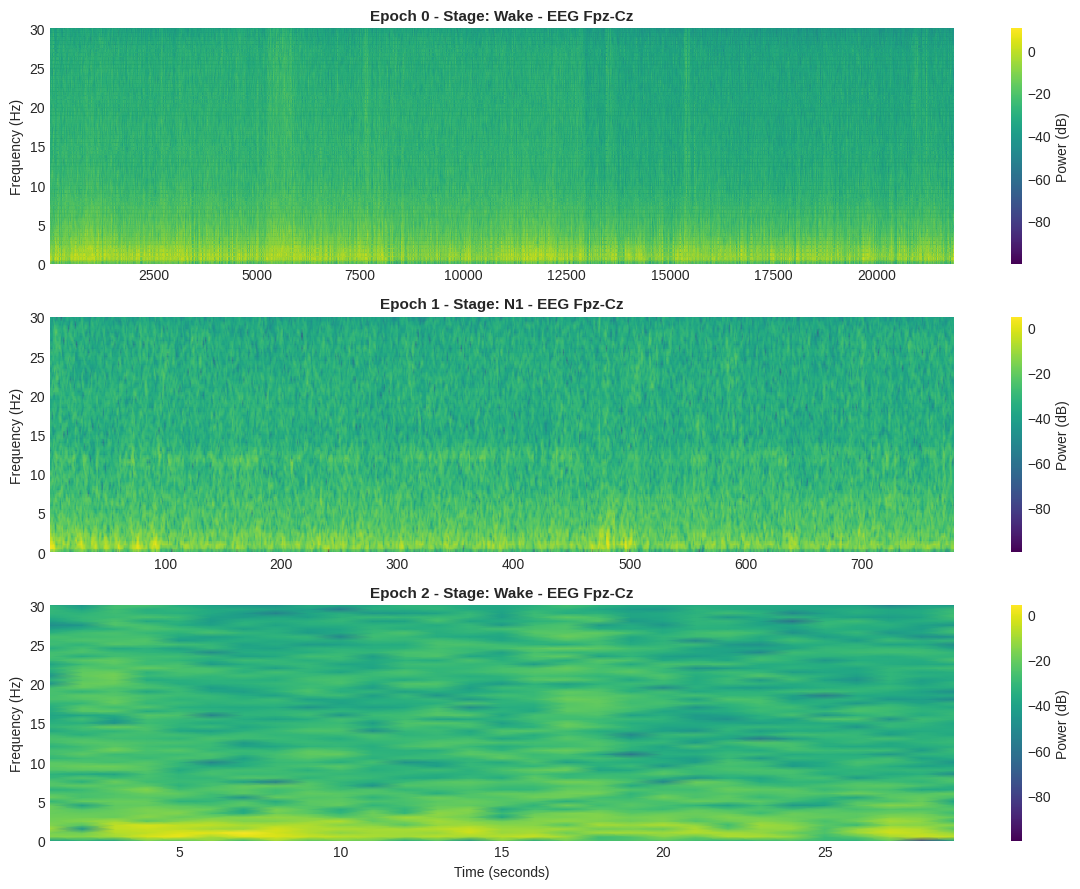

In [12]:
# Visualize frequency domain features
def visualize_spectrogram(subject_data, channel_name=None, num_epochs=5):
    """Visualize spectrograms for sample epochs"""
    if channel_name is None:
        channel_name = list(subject_data['signals'].keys())[0]
    
    signal = subject_data['signals'][channel_name]
    labels = subject_data['labels']
    onsets = subject_data['onsets']
    durations = subject_data['durations']
    sr = subject_data['sampling_rate']
    
    stage_names = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 5: 'REM'}
    
    fig, axes = plt.subplots(num_epochs, 1, figsize=(12, 3*num_epochs))
    
    valid_count = 0
    for i, (onset, duration, label) in enumerate(zip(onsets, durations, labels)):
        if label < 0 or valid_count >= num_epochs:
            continue
        
        start_sample = int(onset * sr)
        end_sample = int((onset + duration) * sr)
        
        if end_sample > len(signal):
            continue
        
        epoch = signal[start_sample:end_sample]
        
        # Compute spectrogram
        freqs, times, Sxx = freq_transformer.compute_spectrogram(epoch)
        
        # Plot
        ax = axes[valid_count] if num_epochs > 1 else axes
        im = ax.pcolormesh(times, freqs, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis')
        ax.set_ylabel('Frequency (Hz)', fontsize=10)
        ax.set_ylim([0, 30])
        ax.set_title(f'Epoch {i} - Stage: {stage_names.get(label, label)} - {channel_name}', 
                     fontsize=11, fontweight='bold')
        plt.colorbar(im, ax=ax, label='Power (dB)')
        
        valid_count += 1
    
    axes[-1].set_xlabel('Time (seconds)', fontsize=10)
    plt.tight_layout()
    plt.show()

if preprocessed_dataset:
    visualize_spectrogram(preprocessed_dataset[0], num_epochs=3)

## 7. PyTorch Datasets and DataLoaders

**Important:** If you get CUDA errors during training, clear GPU memory and recreate the datasets by running the cell below before creating datasets again.

In [13]:
# Clear GPU memory if needed
import gc
import torch

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()
    print("GPU memory cleared")
else:
    print("Running on CPU - no GPU memory to clear")

GPU memory cleared


In [14]:
class TimeDomainDataset(Dataset):
    """Dataset for time-domain EEG signals"""
    
    def __init__(self, dataset, epoch_length=30, sampling_rate=100):
        """
        Args:
            dataset: List of preprocessed subject data
            epoch_length: Length of each epoch in seconds
            sampling_rate: Sampling rate in Hz
        """
        self.epoch_length = epoch_length
        self.sampling_rate = sampling_rate
        self.epoch_samples = int(epoch_length * sampling_rate)
        
        # Label mapping: {0: Wake, 1: N1, 2: N2, 3: N3, 5: REM} -> {0, 1, 2, 3, 4}
        self.label_map = {0: 0, 1: 1, 2: 2, 3: 3, 5: 4}
        
        # Prepare data
        self.samples = []
        self.labels = []
        
        for subject in dataset:
            # Use first channel (or average if multiple channels)
            channel_name = list(subject['signals'].keys())[0]
            signal = subject['signals'][channel_name]
            
            onsets = subject['onsets']
            durations = subject['durations']
            labels = subject['labels']
            
            for onset, duration, label in zip(onsets, durations, labels):
                if label < 0:  # Skip unknown stages
                    continue
                
                start_sample = int(onset * sampling_rate)
                end_sample = int((onset + duration) * sampling_rate)
                
                if end_sample > len(signal):
                    continue
                
                epoch = signal[start_sample:end_sample]
                
                # Ensure fixed length
                if len(epoch) < self.epoch_samples:
                    epoch = np.pad(epoch, (0, self.epoch_samples - len(epoch)), mode='constant')
                elif len(epoch) > self.epoch_samples:
                    epoch = epoch[:self.epoch_samples]
                
                self.samples.append(epoch)
                # Remap label to consecutive indices
                self.labels.append(self.label_map[label])
        
        self.samples = np.array(self.samples, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)
        
        print(f"TimeDomainDataset created: {len(self.samples)} samples")
        print(f"Class distribution: {Counter(self.labels)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Return shape: [sequence_length, input_features]
        # After batching: [batch_size, sequence_length, input_features]
        sample = torch.FloatTensor(self.samples[idx]).unsqueeze(1)  # Shape: [3000, 1]
        label = torch.LongTensor([self.labels[idx]])[0]
        return sample, label

class FrequencyDomainDataset(Dataset):
    """Dataset for frequency-domain EEG signals (spectrograms)"""
    
    def __init__(self, dataset, freq_transformer, max_freq=30):
        """
        Args:
            dataset: List of preprocessed subject data
            freq_transformer: FrequencyTransformer instance
            max_freq: Maximum frequency to include (Hz)
        """
        self.freq_transformer = freq_transformer
        self.max_freq = max_freq
        # Label mapping: {0: Wake, 1: N1, 2: N2, 3: N3, 5: REM} -> {0, 1, 2, 3, 4}
        self.label_map = {0: 0, 1: 1, 2: 2, 3: 3, 5: 4}
        
        # Prepare data
        self.spectrograms = []
        self.labels = []
        
        for subject in dataset:
            channel_name = list(subject['signals'].keys())[0]
            signal = subject['signals'][channel_name]
            
            freq_features, epoch_labels = freq_transformer.segment_and_transform(
                signal, 
                subject['labels'],
                subject['onsets'],
                subject['durations']
            )
            
            for features, label in zip(freq_features, epoch_labels):
                spectrogram = features['spectrogram']
                self.spectrograms.append(spectrogram)
                # Remap label to consecutive indices
                self.labels.append(self.label_map[label])
        
        # Normalize spectrograms and pad to same size
        self.spectrograms = self._normalize_and_pad(self.spectrograms)
        self.labels = np.array(self.labels, dtype=np.int64)
        
        print(f"FrequencyDomainDataset created: {len(self.spectrograms)} spectrograms")
        print(f"Spectrogram shape: {self.spectrograms[0].shape}")
        print(f"Class distribution: {Counter(self.labels)}")
    
    def _normalize_and_pad(self, spectrograms):
        """Normalize and pad spectrograms to same size"""
        # Find max dimensions
        max_freq_bins = max(spec.shape[0] for spec in spectrograms)
        max_time_bins = max(spec.shape[1] for spec in spectrograms)
        
        normalized_specs = []
        for spec in spectrograms:
            # Log transform and normalize
            spec_log = np.log10(spec + 1e-10)
            spec_norm = (spec_log - np.mean(spec_log)) / (np.std(spec_log) + 1e-8)
            
            # Pad to max dimensions
            padded = np.zeros((max_freq_bins, max_time_bins), dtype=np.float32)
            padded[:spec_norm.shape[0], :spec_norm.shape[1]] = spec_norm
            
            normalized_specs.append(padded)
        
        return np.array(normalized_specs, dtype=np.float32)
    
    def __len__(self):
        return len(self.spectrograms)
    
    def __getitem__(self, idx):
        spectrogram = torch.FloatTensor(self.spectrograms[idx]).unsqueeze(0)  # Add channel dimension
        label = torch.LongTensor([self.labels[idx]])[0]
        return spectrogram, label

In [ ]:
# Create datasets using configuration hyperparameters
time_domain_dataset = TimeDomainDataset(preprocessed_dataset, epoch_length=EPOCH_LENGTH, sampling_rate=SAMPLING_RATE)
freq_domain_dataset = FrequencyDomainDataset(preprocessed_dataset, freq_transformer)

# Create dataloaders
time_domain_loader = DataLoader(
    time_domain_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

freq_domain_loader = DataLoader(
    freq_domain_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

print(f"\nDataLoaders created:")
print(f"Time domain batches: {len(time_domain_loader)}")
print(f"Frequency domain batches: {len(freq_domain_loader)}")

# Test dataloaders
time_batch, time_labels = next(iter(time_domain_loader))
freq_batch, freq_labels = next(iter(freq_domain_loader))

print(f"\nTime domain batch shape: {time_batch.shape}  # [batch, seq_len, features]")
print(f"Frequency domain batch shape: {freq_batch.shape}  # [batch, channels, height, width]")
print(f"Labels shape: {time_labels.shape}")

TimeDomainDataset created: 7217 samples
Class distribution: Counter({np.int64(2): 2021, np.int64(1): 1955, np.int64(3): 1529, np.int64(0): 1195, np.int64(4): 517})


## 8. Model Architectures

### 8.1 RNN-based Model (LSTM/GRU) for Time Domain

In [ ]:
class SleepStageRNN(nn.Module):
    """RNN/LSTM/GRU-based model for sleep stage classification"""
    
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, num_classes=5, 
                 rnn_type='LSTM', dropout=0.3, bidirectional=True):
        """
        Args:
            input_size: Number of input channels
            hidden_size: Hidden dimension size
            num_layers: Number of RNN layers
            num_classes: Number of sleep stages (including wake)
            rnn_type: 'RNN', 'LSTM', or 'GRU'
            dropout: Dropout probability
            bidirectional: Use bidirectional RNN
        """
        super(SleepStageRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.rnn_type = rnn_type
        
        # RNN layer
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional
            )
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional
            )
        elif rnn_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional
            )
        else:
            raise ValueError("rnn_type must be 'LSTM', 'GRU', or 'RNN'")
        
        # Output size depends on bidirectional
        rnn_output_size = hidden_size * 2 if bidirectional else hidden_size
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(rnn_output_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        # x shape: (batch, sequence_length, input_features)
        # Already in correct format for RNN
        
        # RNN forward
        rnn_out, _ = self.rnn(x)
        
        # Use the last output
        if self.bidirectional:
            # Concatenate forward and backward last outputs
            last_output = rnn_out[:, -1, :]
        else:
            last_output = rnn_out[:, -1, :]
        
        # Classification
        output = self.fc(last_output)
        
        return output

# Create RNN model
num_classes = len(np.unique(time_domain_dataset.labels))
rnn_model = SleepStageRNN(
    input_size=1,
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    rnn_type='LSTM',
    dropout=0.3,
    bidirectional=True
).to(device)

print(f"RNN Model created with {sum(p.numel() for p in rnn_model.parameters())} parameters")
print(f"Number of classes: {num_classes}")

### 8.2 Transformer Model for Time Domain

In [ ]:
class SleepStageTransformer(nn.Module):
    """Transformer-based model for sleep stage classification"""
    
    def __init__(self, input_size=1, d_model=128, nhead=8, num_layers=4, num_classes=5, dropout=0.3, max_seq_len=3000):
        """
        Args:
            input_size: Number of input channels
            d_model: Dimension of the model
            nhead: Number of attention heads
            num_layers: Number of transformer layers
            num_classes: Number of sleep stages
            dropout: Dropout probability
            max_seq_len: Maximum sequence length
        """
        super(SleepStageTransformer, self).__init__()
        
        self.d_model = d_model
        
        # Input projection
        self.input_projection = nn.Linear(input_size, d_model)
        
        # Positional encoding
        self.pos_encoder = self._create_positional_encoding(max_seq_len, d_model)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )
    
    def _create_positional_encoding(self, max_len, d_model):
        """Create positional encoding"""
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        return pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
    
    def forward(self, x):
        # x shape: (batch, sequence_length, input_features)
        # Already in correct format for Transformer
        
        batch_size, seq_len, _ = x.shape
        
        # Project input
        x = self.input_projection(x)
        
        # Add positional encoding
        pos_encoding = self.pos_encoder[:, :seq_len, :].to(x.device)
        x = x + pos_encoding
        
        # Transformer encoding
        x = self.transformer_encoder(x)
        
        # Global average pooling
        x = torch.mean(x, dim=1)
        
        # Classification
        output = self.classifier(x)
        
        return output

# Create Transformer model
transformer_model = SleepStageTransformer(
    input_size=1,
    d_model=128,
    nhead=8,
    num_layers=4,
    num_classes=num_classes,
    dropout=0.3,
    max_seq_len=3000
).to(device)

print(f"Transformer Model created with {sum(p.numel() for p in transformer_model.parameters())} parameters")

### 8.3 CNN Model for Frequency Domain

In [ ]:
class SleepStageCNN(nn.Module):
    """CNN-based model for sleep stage classification from spectrograms"""
    
    def __init__(self, input_channels=1, num_classes=5, dropout=0.3):
        """
        Args:
            input_channels: Number of input channels (1 for single spectrogram)
            num_classes: Number of sleep stages
            dropout: Dropout probability
        """
        super(SleepStageCNN, self).__init__()
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Conv block 1
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(dropout),
            
            # Conv block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(dropout),
            
            # Conv block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(dropout),
            
            # Conv block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        # x shape: (batch, channels, freq_bins, time_bins)
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

# Create CNN model
cnn_model = SleepStageCNN(
    input_channels=1,
    num_classes=num_classes,
    dropout=0.3
).to(device)

print(f"CNN Model created with {sum(p.numel() for p in cnn_model.parameters())} parameters")

### 8.4 Vision Transformer (ViT) for Frequency Domain

In [ ]:
class SleepStageViT(nn.Module):
    """Vision Transformer for sleep stage classification from spectrograms"""
    
    def __init__(self, img_size=(30, 60), patch_size=5, in_channels=1, 
                 embed_dim=128, num_heads=8, num_layers=6, num_classes=5, dropout=0.3):
        """
        Args:
            img_size: Size of input image (freq_bins, time_bins)
            patch_size: Size of each patch
            in_channels: Number of input channels
            embed_dim: Embedding dimension
            num_heads: Number of attention heads
            num_layers: Number of transformer layers
            num_classes: Number of sleep stages
            dropout: Dropout probability
        """
        super(SleepStageViT, self).__init__()
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size[0] // patch_size) * (img_size[1] // patch_size)
        self.embed_dim = embed_dim
        
        # Patch embedding
        self.patch_embed = nn.Conv2d(
            in_channels, 
            embed_dim, 
            kernel_size=patch_size, 
            stride=patch_size
        )
        
        # Class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        # Positional embedding
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            batch_first=True
        )
        
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        
        # Classification head
        self.head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # x shape: (batch, channels, height, width)
        batch_size = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed(x)  # (batch, embed_dim, H/P, W/P)
        x = x.flatten(2)  # (batch, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (batch, num_patches, embed_dim)
        
        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        
        # Add positional embedding
        x = x + self.pos_embed
        x = self.dropout(x)
        
        # Transformer
        x = self.transformer(x)
        
        # Classification using class token
        cls_output = x[:, 0]
        output = self.head(cls_output)
        
        return output

# Get spectrogram size from data
sample_spec = freq_domain_dataset.spectrograms[0]
spec_height, spec_width = sample_spec.shape

# Adjust patch size to fit the spectrogram dimensions
patch_size = 5
# Ensure dimensions are divisible by patch size
img_height = (spec_height // patch_size) * patch_size
img_width = (spec_width // patch_size) * patch_size

print(f"Spectrogram size: {sample_spec.shape}")
print(f"Adjusted size for ViT: ({img_height}, {img_width})")

# Create ViT model
vit_model = SleepStageViT(
    img_size=(img_height, img_width),
    patch_size=patch_size,
    in_channels=1,
    embed_dim=128,
    num_heads=8,
    num_layers=6,
    num_classes=num_classes,
    dropout=0.3
).to(device)

print(f"ViT Model created with {sum(p.numel() for p in vit_model.parameters())} parameters")

## 9. Loss Functions and Metrics

In [ ]:
class MetricsCalculator:
    """Calculate classification metrics"""
    
    def __init__(self, num_classes, class_names=None):
        self.num_classes = num_classes
        self.class_names = class_names or [f'Class {i}' for i in range(num_classes)]
    
    def calculate_metrics(self, y_true, y_pred, y_pred_proba=None):
        """
        Calculate comprehensive classification metrics
        
        Args:
            y_true: True labels
            y_pred: Predicted labels
            y_pred_proba: Predicted probabilities (for AUROC)
        
        Returns:
            Dictionary of metrics
        """
        metrics = {}
        
        # Accuracy
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        
        # Precision, Recall, F1 (weighted for multiclass)
        metrics['precision'] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        metrics['recall'] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        metrics['f1'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        # Per-class metrics
        precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
        recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
        f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
        
        for i, class_name in enumerate(self.class_names):
            if i < len(precision_per_class):
                metrics[f'precision_{class_name}'] = precision_per_class[i]
                metrics[f'recall_{class_name}'] = recall_per_class[i]
                metrics[f'f1_{class_name}'] = f1_per_class[i]
        
        # AUROC (if probabilities provided)
        if y_pred_proba is not None:
            try:
                # Convert to one-hot for multiclass AUROC
                from sklearn.preprocessing import label_binarize
                y_true_bin = label_binarize(y_true, classes=range(self.num_classes))
                
                if y_true_bin.shape[1] == self.num_classes:
                    metrics['auroc'] = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
            except Exception as e:
                print(f"Could not calculate AUROC: {e}")
                metrics['auroc'] = None
        else:
            metrics['auroc'] = None
        
        # Confusion matrix
        metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred)
        
        return metrics
    
    def print_metrics(self, metrics):
        """Print metrics in a formatted way"""
        print("=" * 60)
        print("CLASSIFICATION METRICS")
        print("=" * 60)
        print(f"Accuracy:  {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall:    {metrics['recall']:.4f}")
        print(f"F1 Score:  {metrics['f1']:.4f}")
        
        if metrics.get('auroc') is not None:
            print(f"AUROC:     {metrics['auroc']:.4f}")
        
        print("\nPer-Class Metrics:")
        print("-" * 60)
        for class_name in self.class_names:
            prec = metrics.get(f'precision_{class_name}', 0)
            rec = metrics.get(f'recall_{class_name}', 0)
            f1 = metrics.get(f'f1_{class_name}', 0)
            print(f"{class_name:10s} - Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
        
        print("=" * 60)
    
    def plot_confusion_matrix(self, cm, normalize=False):
        """Plot confusion matrix"""
        if normalize:
            cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-10)
            title = 'Normalized Confusion Matrix'
            fmt = '.2f'
        else:
            title = 'Confusion Matrix'
            fmt = 'd'
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', 
                    xticklabels=self.class_names, 
                    yticklabels=self.class_names)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title(title, fontweight='bold')
        plt.tight_layout()
        plt.show()

# Map sleep stage labels to names
# After remapping: {0: Wake, 1: N1, 2: N2, 3: N3, 4: REM}
stage_mapping = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
unique_labels = np.unique(time_domain_dataset.labels)
class_names = [stage_mapping.get(label, f'Stage_{label}') for label in sorted(unique_labels)]

# Initialize metrics calculator
metrics_calculator = MetricsCalculator(num_classes=num_classes, class_names=class_names)

# Determine loss function based on number of classes
if num_classes == 2:
    print("Using Binary Cross Entropy Loss (2 classes)")
    # For binary classification, we'd need to adjust the model output
    criterion = nn.CrossEntropyLoss()  # Still use this, PyTorch handles it
else:
    print(f"Using Categorical Cross Entropy Loss ({num_classes} classes)")
    criterion = nn.CrossEntropyLoss()

print(f"\nClass names: {class_names}")
print(f"Loss function: {criterion.__class__.__name__}")

## 10. K-Fold Cross Validation Training Pipeline

In [ ]:
class KFoldTrainer:
    """K-Fold cross validation trainer"""
    
    def __init__(self, model, criterion, metrics_calculator, device, k_folds=K_FOLDS):
        """
        Args:
            model: PyTorch model class (not instance)
            criterion: Loss function
            metrics_calculator: MetricsCalculator instance
            device: Device to train on
            k_folds: Number of folds
        """
        self.model_class = model
        self.criterion = criterion
        self.metrics_calculator = metrics_calculator
        self.device = device
        self.k_folds = k_folds
    
    def train_epoch(self, model, train_loader, optimizer):
        """Train for one epoch"""
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        all_probs = []
        
        for batch_x, batch_y in tqdm(train_loader, desc='Training', leave=False):
            batch_x = batch_x.to(self.device)
            batch_y = batch_y.to(self.device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = self.criterion(outputs, batch_y)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probs.extend(probs.cpu().detach().numpy())
        
        avg_loss = total_loss / len(train_loader)
        
        # Calculate comprehensive metrics for training
        metrics = self.metrics_calculator.calculate_metrics(
            all_labels,
            all_preds,
            np.array(all_probs)
        )
        
        return avg_loss, metrics
    
    def validate(self, model, val_loader):
        """Validate the model"""
        model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for batch_x, batch_y in tqdm(val_loader, desc='Validation', leave=False):
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)
                
                outputs = model(batch_x)
                loss = self.criterion(outputs, batch_y)
                
                total_loss += loss.item()
                
                probs = F.softmax(outputs, dim=1)
                preds = torch.argmax(outputs, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch_y.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        avg_loss = total_loss / len(val_loader)
        
        # Calculate metrics
        metrics = self.metrics_calculator.calculate_metrics(
            all_labels, 
            all_preds, 
            np.array(all_probs)
        )
        
        return avg_loss, metrics
    
    def train_kfold(self, dataset, model_params, epochs=NUM_EPOCHS, lr=LEARNING_RATE, batch_size=BATCH_SIZE):
        """
        Train with K-Fold cross validation
        
        Args:
            dataset: PyTorch Dataset
            model_params: Dictionary of model parameters
            epochs: Number of epochs per fold
            lr: Learning rate
            batch_size: Batch size
        
        Returns:
            best_fold_results: Best performance from each fold
        """
        kfold = KFold(n_splits=self.k_folds, shuffle=True, random_seed=RANDOM_SEED)
        
        best_fold_results = []
        
        # Get all data
        all_data = []
        all_labels = []
        for i in range(len(dataset)):
            data, label = dataset[i]
            all_data.append(data)
            all_labels.append(label)
        
        all_data = torch.stack(all_data)
        all_labels = torch.tensor(all_labels)
        
        print(f"\n{'='*80}")
        print(f"Starting {self.k_folds}-Fold Cross Validation")
        print(f"{'='*80}\n")
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(all_data)):
            print(f"\n{'='*80}")
            print(f"FOLD {fold + 1}/{self.k_folds}")
            print(f"{'='*80}")
            
            # Create data subsets
            train_data = torch.utils.data.Subset(dataset, train_idx)
            val_data = torch.utils.data.Subset(dataset, val_idx)
            
            # Compute class weights for handling class imbalance
            train_labels = [dataset[i][1].item() for i in train_idx]
            class_counts = np.bincount(train_labels)
            class_weights = 1.0 / (class_counts + 1e-6)
            sample_weights = [class_weights[label] for label in train_labels]
            sampler = torch.utils.data.WeightedRandomSampler(
                weights=sample_weights,
                num_samples=len(sample_weights),
                replacement=True
            )
            
            # Create data loaders with weighted sampling for training
            train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler, num_workers=0)
            val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)
            
            print(f"Train samples: {len(train_data)}, Val samples: {len(val_data)}")
            print(f"Class distribution (train): {dict(enumerate(class_counts))}")
            
            # Initialize model
            model = self.model_class(**model_params).to(self.device)
            optimizer = AdamW(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=LR_SCHEDULER_FACTOR, patience=LR_SCHEDULER_PATIENCE)
            
            best_val_loss = float('inf')
            best_val_f1 = 0.0
            best_metrics = None
            best_epoch = 0
            patience_counter = 0
            
            # Training loop
            for epoch in range(epochs):
                print(f"\nEpoch {epoch + 1}/{epochs}")
                print("-" * 40)
                
                train_loss, train_metrics = self.train_epoch(model, train_loader, optimizer)
                val_loss, val_metrics = self.validate(model, val_loader)
                
                print(f"Train Loss: {train_loss:.4f}, Acc: {train_metrics['accuracy']:.4f}, "
                      f"Prec: {train_metrics['precision']:.4f}, Rec: {train_metrics['recall']:.4f}, "
                      f"F1: {train_metrics['f1']:.4f}")
                print(f"Val   Loss: {val_loss:.4f}, Acc: {val_metrics['accuracy']:.4f}, "
                      f"Prec: {val_metrics['precision']:.4f}, Rec: {val_metrics['recall']:.4f}, "
                      f"F1: {val_metrics['f1']:.4f}")
                if train_metrics.get('auroc') and val_metrics.get('auroc'):
                    print(f"AUROC - Train: {train_metrics['auroc']:.4f}, Val: {val_metrics['auroc']:.4f}")
                
                scheduler.step(val_loss)
                
                # Save best model based on F1 score
                if val_metrics['f1'] > best_val_f1:
                    best_val_f1 = val_metrics['f1']
                    best_val_loss = val_loss
                    best_metrics = val_metrics
                    best_epoch = epoch + 1
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                # Early stopping
                if patience_counter >= EARLY_STOPPING_PATIENCE:
                    print(f"\nEarly stopping triggered after {epoch + 1} epochs")
                    break
            
            # Store only best performance for this fold
            best_fold_results.append({
                'fold': fold + 1,
                'best_epoch': best_epoch,
                'best_val_loss': best_val_loss,
                'best_val_f1': best_val_f1,
                'metrics': best_metrics
            })
            
            print(f"\nBest performance at epoch {best_epoch}: Val Loss={best_val_loss:.4f}, Val F1={best_val_f1:.4f}")
            self.metrics_calculator.print_metrics(best_metrics)
        
        # Print summary
        print(f"\n{'='*80}")
        print("K-FOLD CROSS VALIDATION SUMMARY")
        print(f"{'='*80}\n")
        
        avg_metrics = self._average_fold_results(best_fold_results)
        self.metrics_calculator.print_metrics(avg_metrics)
        
        # Print best epochs for each fold
        print(f"\nBest Epochs per Fold:")
        for result in best_fold_results:
            print(f"  Fold {result['fold']}: Epoch {result['best_epoch']} (F1={result['best_val_f1']:.4f})")
        
        return best_fold_results, avg_metrics
    
    def _average_fold_results(self, fold_results):
        """Average metrics across folds"""
        avg_metrics = {}
        
        # Collect all metric keys
        metric_keys = [k for k in fold_results[0]['metrics'].keys() if k != 'confusion_matrix']
        
        for key in metric_keys:
            values = [fold['metrics'][key] for fold in fold_results if fold['metrics'][key] is not None]
            if values:
                avg_metrics[key] = np.mean(values)
            else:
                avg_metrics[key] = None
        
        # Average confusion matrix
        cms = [fold['metrics']['confusion_matrix'] for fold in fold_results]
        avg_metrics['confusion_matrix'] = np.mean(cms, axis=0).astype(int)
        
        return avg_metrics

print("K-Fold Trainer class defined")

### 10.1 Train RNN Model (Time Domain)

In [ ]:
# RNN Model Parameters (using configuration hyperparameters)
rnn_params = {
    'input_size': 1,
    'hidden_size': HIDDEN_SIZE,
    'num_layers': NUM_RNN_LAYERS,
    'num_classes': NUM_CLASSES,
    'rnn_type': 'LSTM',
    'dropout': DROPOUT,
    'bidirectional': True
}

# Train RNN with K-Fold
rnn_trainer = KFoldTrainer(
    model=SleepStageRNN,
    criterion=criterion,
    metrics_calculator=metrics_calculator,
    device=device,
    k_folds=K_FOLDS
)

print("Training RNN Model with K-Fold Cross Validation...")
rnn_results, rnn_avg_metrics = rnn_trainer.train_kfold(
    dataset=time_domain_dataset,
    model_params=rnn_params
)

# Clear GPU memory after training
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()
    print("GPU memory cleared after RNN training")

In [ ]:
# Plot RNN confusion matrix
metrics_calculator.plot_confusion_matrix(rnn_avg_metrics['confusion_matrix'], normalize=True)

### 10.2 Train Transformer Model (Time Domain)

In [ ]:
# Transformer Model Parameters (using configuration hyperparameters)
transformer_params = {
    'input_size': 1,
    'd_model': D_MODEL,
    'nhead': NUM_HEADS,
    'num_layers': NUM_TRANSFORMER_LAYERS,
    'num_classes': NUM_CLASSES,
    'dropout': DROPOUT,
    'max_seq_len': MAX_SEQ_LEN
}

# Train Transformer with K-Fold
transformer_trainer = KFoldTrainer(
    model=SleepStageTransformer,
    criterion=criterion,
    metrics_calculator=metrics_calculator,
    device=device,
    k_folds=K_FOLDS
)

print("Training Transformer Model with K-Fold Cross Validation...")
transformer_results, transformer_avg_metrics = transformer_trainer.train_kfold(
    dataset=time_domain_dataset,
    model_params=transformer_params,
    lr=LEARNING_RATE * 0.5  # Transformers often benefit from lower learning rate
)

# Clear GPU memory after training
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()
    print("GPU memory cleared after Transformer training")

In [ ]:
# Plot Transformer confusion matrix
metrics_calculator.plot_confusion_matrix(transformer_avg_metrics['confusion_matrix'], normalize=True)

### 10.3 Train CNN Model (Frequency Domain)

In [ ]:
# CNN Model Parameters (using configuration hyperparameters)
cnn_params = {
    'input_channels': 1,
    'num_classes': NUM_CLASSES,
    'dropout': DROPOUT
}

# Train CNN with K-Fold
cnn_trainer = KFoldTrainer(
    model=SleepStageCNN,
    criterion=criterion,
    metrics_calculator=metrics_calculator,
    device=device,
    k_folds=K_FOLDS
)

print("Training CNN Model with K-Fold Cross Validation...")
cnn_results, cnn_avg_metrics = cnn_trainer.train_kfold(
    dataset=freq_domain_dataset,
    model_params=cnn_params
)

# Clear GPU memory after training
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()
    print("GPU memory cleared after CNN training")

In [ ]:
# Plot CNN confusion matrix
metrics_calculator.plot_confusion_matrix(cnn_avg_metrics['confusion_matrix'], normalize=True)

### 10.4 Train ViT Model (Frequency Domain)

In [ ]:
# ViT Model Parameters (using configuration hyperparameters)
vit_params = {
    'img_size': (img_height, img_width),
    'patch_size': patch_size,
    'in_channels': 1,
    'embed_dim': D_MODEL,
    'num_heads': NUM_HEADS,
    'num_layers': NUM_TRANSFORMER_LAYERS,
    'num_classes': NUM_CLASSES,
    'dropout': DROPOUT
}

# Train ViT with K-Fold
vit_trainer = KFoldTrainer(
    model=SleepStageViT,
    criterion=criterion,
    metrics_calculator=metrics_calculator,
    device=device,
    k_folds=K_FOLDS
)

print("Training ViT Model with K-Fold Cross Validation...")
vit_results, vit_avg_metrics = vit_trainer.train_kfold(
    dataset=freq_domain_dataset,
    model_params=vit_params,
    lr=LEARNING_RATE * 0.5  # ViT often benefits from lower learning rate
)

# Clear GPU memory after training
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()
    print("GPU memory cleared after ViT training")

In [ ]:
# Plot ViT confusion matrix
metrics_calculator.plot_confusion_matrix(vit_avg_metrics['confusion_matrix'], normalize=True)

## 11. Model Comparison and Final Results

In [ ]:
# Compare all models
def compare_models(model_results):
    """Compare performance of all models"""
    comparison_df = pd.DataFrame({
        'Model': list(model_results.keys()),
        'Accuracy': [results['accuracy'] for results in model_results.values()],
        'Precision': [results['precision'] for results in model_results.values()],
        'Recall': [results['recall'] for results in model_results.values()],
        'F1 Score': [results['f1'] for results in model_results.values()],
        'AUROC': [results.get('auroc', 0) or 0 for results in model_results.values()]
    })
    
    comparison_df = comparison_df.sort_values('F1 Score', ascending=False)
    
    print("\n" + "="*80)
    print("MODEL COMPARISON")
    print("="*80)
    print(comparison_df.to_string(index=False))
    print("="*80)
    
    # Plot comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    colors = sns.color_palette("husl", len(model_results))
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 2, idx % 2]
        values = comparison_df[metric].values
        models = comparison_df['Model'].values
        
        bars = ax.bar(models, values, color=colors, edgecolor='black', alpha=0.7)
        ax.set_ylabel(metric, fontsize=11)
        ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
        ax.set_ylim([0, 1])
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

# Collect results from all models
all_model_results = {
    'RNN (LSTM)': rnn_avg_metrics,
    'Transformer': transformer_avg_metrics,
    'CNN': cnn_avg_metrics,
    'ViT': vit_avg_metrics
}

comparison_results = compare_models(all_model_results)

## 12. Summary and Next Steps

### Summary
This notebook implemented a complete pipeline for sleep stage detection from EEG signals:

1. **Data Loading**: Successfully loaded EDF files containing PSG and hypnogram data
2. **EDA**: Explored raw signal characteristics and sleep stage distributions
3. **Preprocessing**: Applied bandpass filtering, notch filtering, artifact removal, and normalization
4. **Frequency Transform**: Converted signals to frequency domain using spectrograms
5. **Datasets**: Created separate dataloaders for time-domain and frequency-domain data
6. **Models**: Implemented 4 different architectures:
   - **RNN (LSTM)**: Bidirectional LSTM for time-domain signals
   - **Transformer**: Attention-based model for time-domain signals
   - **CNN**: Convolutional neural network for spectrograms
   - **ViT**: Vision Transformer for spectrograms
7. **Training**: Used K-Fold cross-validation with proper metrics (Accuracy, Precision, Recall, F1, AUROC)
8. **Evaluation**: Comprehensive performance comparison across all models

### Key Features
- ✅ Proper categorical cross-entropy loss for multi-class classification
- ✅ Comprehensive metrics: Accuracy, Precision, Recall, F1-Score, AUROC
- ✅ K-Fold cross-validation for robust evaluation
- ✅ Early stopping and learning rate scheduling
- ✅ Confusion matrix visualization
- ✅ Both time-domain and frequency-domain approaches

### Next Steps for Full Training
To run on the full dataset:
1. Set `NUM_SUBJECTS = None` to load all subjects
2. Increase `k_folds=5` for more robust cross-validation
3. Increase `epochs=20` or more for better convergence
4. Consider class balancing techniques for imbalanced sleep stages
5. Experiment with:
   - Different preprocessing parameters
   - Model hyperparameters
   - Ensemble methods combining multiple models
   - Data augmentation techniques
6. Save best models for inference
7. Test on held-out test set

### Notes
- Current configuration uses only 2 subjects for testing
- Models use 3-fold CV and 5 epochs for quick validation
- All code is ready to scale to full dataset by changing configuration parameters